In [4]:
# 1. Imports and Safe Loader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

# PIL robust loading for all image problems
ImageFile.LOAD_TRUNCATED_IMAGES = True

def rgb_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

from torchvision.datasets import ImageFolder
class SafeImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs, loader=rgb_loader)
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except Exception as e:
            print(f"Skipped image at index {index}: {e}")
            return self.__getitem__((index + 1) % len(self))


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 2. Dataset and Data Augmentation
train_dir = '/content/drive/MyDrive/EDGE_AI_DATASET/train'
test_dir = '/content/drive/MyDrive/EDGE_AI_DATASET/test'

IMAGE_SIZE = 128
BATCH_SIZE = 32
N_WORKERS = 2

# Aggressive augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = SafeImageFolder(root=train_dir, transform=train_transform)
test_dataset = SafeImageFolder(root=test_dir, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

# Print dataset info
print("Classes:", train_dataset.classes)
print("Number of classes:", len(train_dataset.classes))
print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))


Classes: ['bed', 'bottles', 'car', 'cellphone', 'chair', 'college', 'furniture', 'indoor', 'monitor', 'nameboard', 'office', 'railwaystations', 'road', 'school', 'signboard', 'sofas', 'toys', 'trafficsignal', 'tv']
Number of classes: 19
Number of training samples: 4570
Number of test samples: 1131


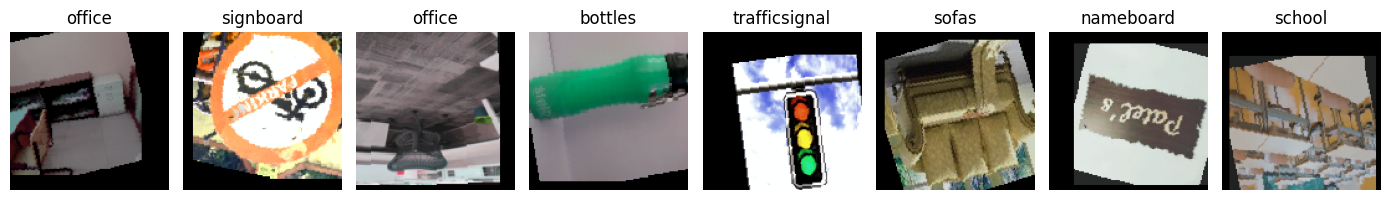

In [ ]:
# 3. Visualize Data Batch
def imshow(img, mean, std):
    img = img.permute(1, 2, 0).numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images, labels = next(iter(train_loader))
plt.figure(figsize=(14,4))
for i in range(8):
    plt.subplot(1,8,i+1)
    imshow(images[i].cpu(), mean, std)
    plt.title(train_dataset.classes[labels[i]])
plt.tight_layout()
plt.show()


In [6]:
# 4. BigCustomCNN Definition
class BigCustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)
        with torch.no_grad():
            dummy = torch.zeros(1,3,IMAGE_SIZE,IMAGE_SIZE)
            x = self.pool(F.relu(self.bn1(self.conv1(dummy))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            x = self.pool(F.relu(self.bn4(self.conv4(x))))
            x = self.pool(F.relu(self.bn5(self.conv5(x))))
            n_flat = x.view(1,-1).shape[1]
        self.fc1 = nn.Linear(n_flat, 512)
        self.fc2 = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# 5. Training Setup & Smart Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)
model = BigCustomCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

NUM_EPOCHS = 50
PATIENCE = 6

train_losses, test_losses, train_accs, test_accs = [], [], [], []
best_test_acc = 0
no_improve_epochs = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # --- Eval on Test ---
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total * 100
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    # Early stopping and checkpoint
    if test_acc > best_test_acc:
        torch.save(model.state_dict(), 'best_bigcustomcnn.pth')
        best_test_acc = test_acc
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    if no_improve_epochs >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

print("\n=== TRAINING COMPLETE! ===")
print(f"Best test accuracy: {best_test_acc:.2f}%")


Epoch 1/50 | Train Acc: 17.21% | Test Acc: 23.52%
Epoch 2/50 | Train Acc: 28.73% | Test Acc: 34.48%
Epoch 3/50 | Train Acc: 32.82% | Test Acc: 39.70%
Epoch 4/50 | Train Acc: 35.76% | Test Acc: 41.56%
Epoch 5/50 | Train Acc: 37.71% | Test Acc: 41.38%
Epoch 6/50 | Train Acc: 41.18% | Test Acc: 42.88%
Epoch 7/50 | Train Acc: 43.08% | Test Acc: 44.30%
Epoch 8/50 | Train Acc: 44.15% | Test Acc: 46.07%
Epoch 9/50 | Train Acc: 45.37% | Test Acc: 50.66%
Epoch 10/50 | Train Acc: 47.14% | Test Acc: 46.42%
Epoch 11/50 | Train Acc: 48.56% | Test Acc: 49.69%
Epoch 12/50 | Train Acc: 50.07% | Test Acc: 48.81%
Epoch 13/50 | Train Acc: 50.48% | Test Acc: 53.32%
Epoch 14/50 | Train Acc: 52.07% | Test Acc: 56.68%
Epoch 15/50 | Train Acc: 53.45% | Test Acc: 56.06%
Epoch 16/50 | Train Acc: 54.69% | Test Acc: 59.68%
Epoch 17/50 | Train Acc: 57.05% | Test Acc: 54.73%
Epoch 18/50 | Train Acc: 55.76% | Test Acc: 60.30%
Epoch 19/50 | Train Acc: 56.57% | Test Acc: 60.48%
Epoch 20/50 | Train Acc: 56.81% | Test A

Classification Report:

                 precision    recall  f1-score   support

            bed       0.76      0.63      0.69        60
        bottles       0.85      0.97      0.91        60
            car       0.87      0.78      0.82        60
      cellphone       0.87      0.77      0.81        60
          chair       0.69      0.88      0.77        60
        college       0.31      0.48      0.37        60
      furniture       0.93      0.95      0.94        58
         indoor       0.21      0.18      0.20        60
        monitor       0.97      0.63      0.77        60
      nameboard       0.94      0.75      0.83        60
         office       0.41      0.26      0.32        53
railwaystations       0.94      0.97      0.95        60
           road       0.95      0.98      0.97        60
         school       0.50      0.20      0.29        60
      signboard       0.64      0.75      0.69        60
          sofas       0.82      0.83      0.83        60
      

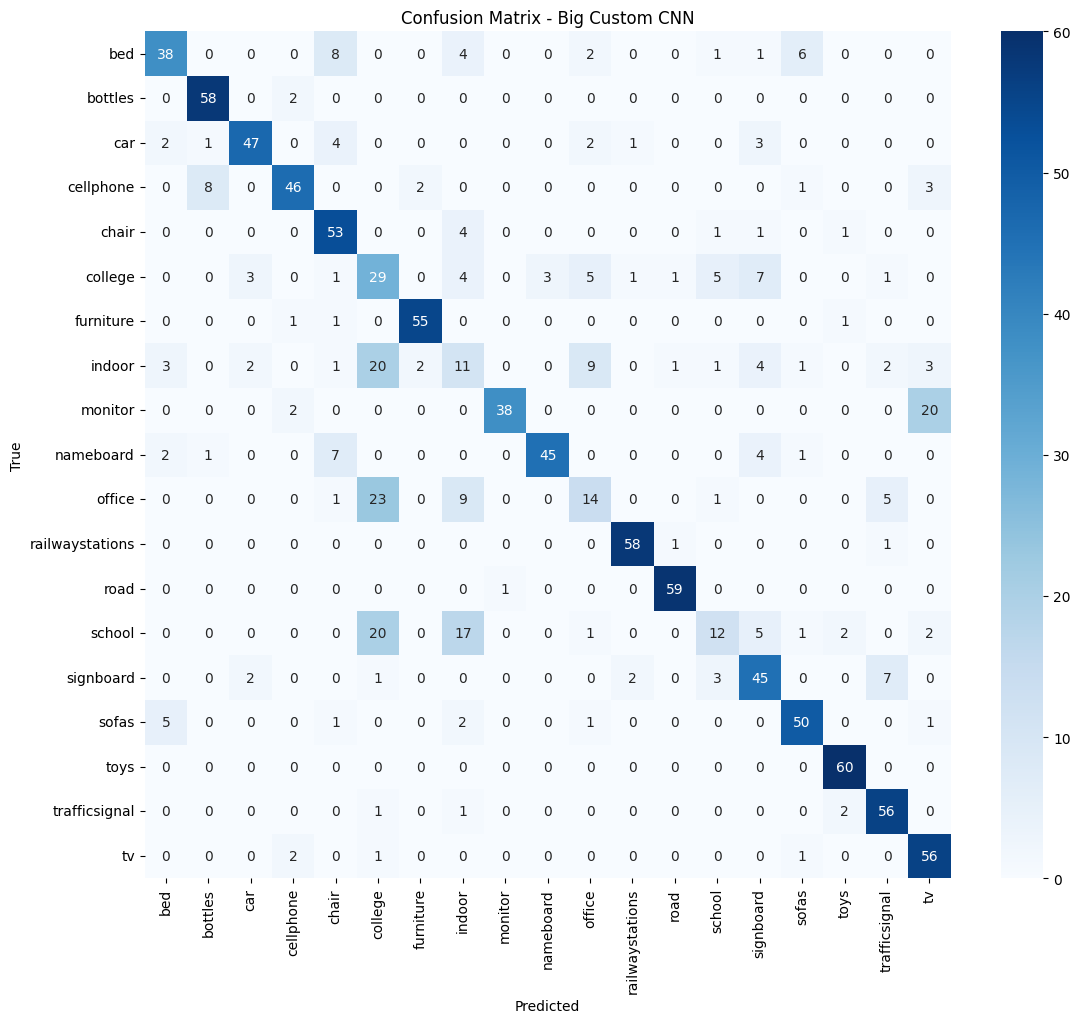

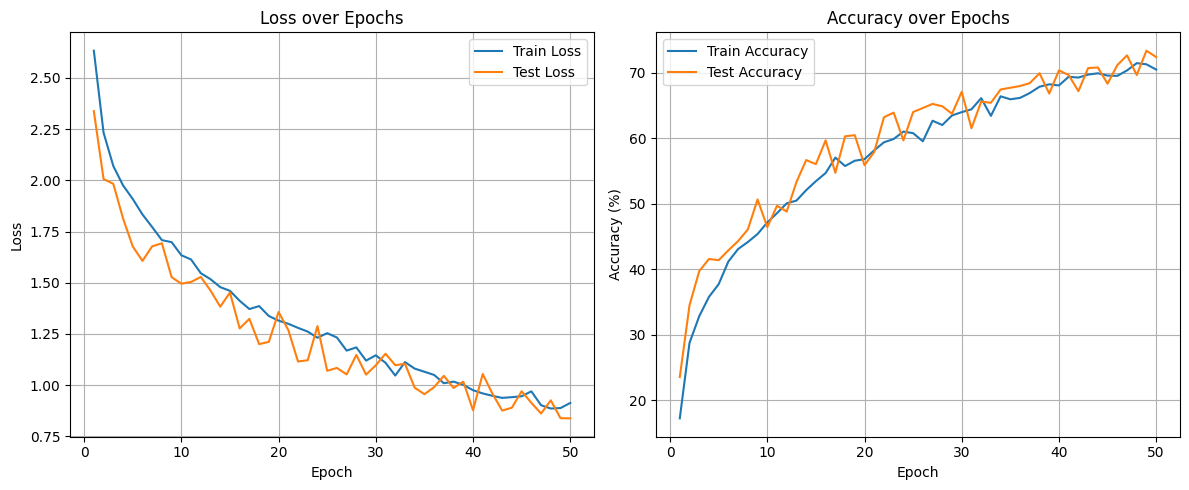


=== FINAL TEST ACCURACY (Best Model): 73.39% ===


In [ ]:
# 6. Evaluation & Visualization
model.load_state_dict(torch.load('best_bigcustomcnn.pth'))
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes, zero_division=0))

print("\nConfusion Matrix:\n")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(13,11))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Big Custom CNN')
plt.show()

# Loss and Accuracy Curves
epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n=== FINAL TEST ACCURACY (Best Model): {best_test_acc:.2f}% ===")


Output of Model:
car: 99.98%
office: 0.02%
chair: 0.00%
bed: 0.00%
nameboard: 0.00%


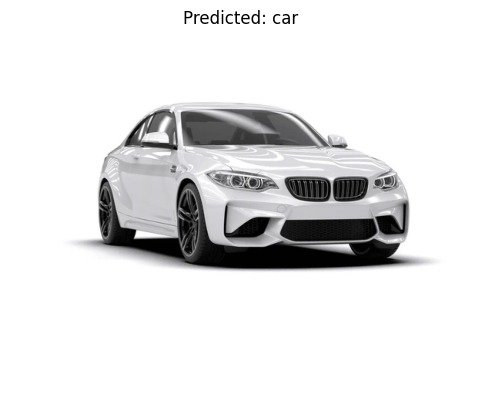

Output of Model:
chair: 99.98%
bed: 0.01%
furniture: 0.01%
office: 0.00%
sofas: 0.00%


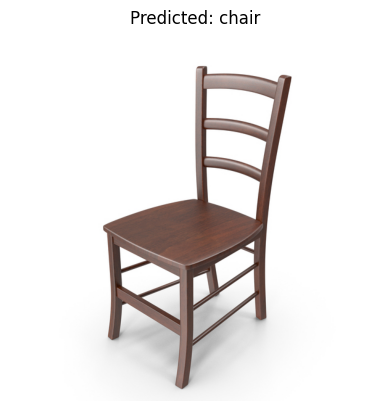

Output of Model:
bed: 43.66%
bottles: 17.96%
sofas: 16.05%
chair: 7.48%
cellphone: 5.78%


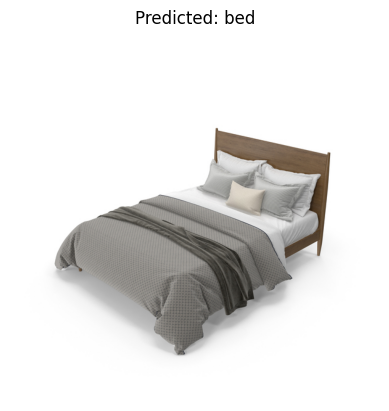

In [12]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Redefine your model class here (same as in training)
class BigCustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)
        with torch.no_grad():
            dummy = torch.zeros(1,3,IMAGE_SIZE,IMAGE_SIZE)
            x = self.pool(F.relu(self.bn1(self.conv1(dummy))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            x = self.pool(F.relu(self.bn4(self.conv4(x))))
            x = self.pool(F.relu(self.bn5(self.conv5(x))))
            n_flat = x.view(1,-1).shape[1]
        self.fc1 = nn.Linear(n_flat, 512)
        self.fc2 = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    pass

def load_model(weights_path, device, num_classes):
    model = BigCustomCNN(num_classes).to(device)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()
    return model

def rgb_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert("RGB")

def predict(image_path, model, class_names, device):
    test_transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = rgb_loader(image_path)
    input_tensor = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)[0]
        top5_probs, top5_indices = torch.topk(probabilities, 5)

    print("Output of Model:")
    for idx, prob in zip(top5_indices, top5_probs):
        print(f"{class_names[idx]}: {prob.item()*100:.2f}%")

    plt.figure()
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[top5_indices[0]]}")
    plt.axis("off")
    plt.show()

# Main usage example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 19
class_names = [
    'bed', 'bottles', 'car', 'cellphone', 'chair', 'college', 'furniture', 'indoor',
    'monitor', 'nameboard', 'office', 'railwaystations', 'road', 'school', 'signboard',
    'sofas', 'toys', 'trafficsignal', 'tv'
]
weights_path = '/content/best_bigcustomcnn.pth'

# For each image, call:
model = load_model(weights_path, device, num_classes)
image_path = "/content/bmw.jpg.webp"
predict(image_path, model, class_names, device)

model = load_model(weights_path, device, num_classes)
image_path = "/content/chair-dining-D5xL0AA-600.jpg"
predict(image_path, model, class_names, device)


model = load_model(weights_path, device, num_classes)
image_path = "/content/bed.jpg"
predict(image_path, model, class_names, device)


